# Загрузка данных

In [ ]:
import pandas as pd
import os
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
import joblib
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import catboost

In [ ]:
sklearn.__version__

'0.22.1'

In [ ]:
rheed_long = pd.read_csv("ONTI_Dataset_parsed.csv")

In [ ]:
#проверка на корректную склейку
print(rheed_long.shape)
rheed_long[:1]

(2363772, 20)


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Coolness_RHEED,Length_RHEED,R FWHM_RHEED,Speed_RHEED,Time_RHEED,X FWHM_RHEED,Y FWHM_RHEED,Crystal Position,Displayed Rate,Filtered Rate,Fundamental Freq,Length,Raw Rate,Source Power,Speed,Time
0,0,0.0,0.0,0.0,0.0,0.003721,0.0,0.040601,2021-02-23 02:21:05,0.0,0.0,1.0,6.025618,5.999182,5967367.0,0.003721,5.987163,21.6351,NaN,2021-02-23 02:21:05


In [ ]:

rheed_long.shape

(2363772, 20)

In [ ]:
#важные колонки для использования
val_col = ['Coolness_RHEED',  'R FWHM_RHEED',  'X FWHM_RHEED', 'Y FWHM_RHEED',
        'Filtered Rate', 'Displayed Rate', 'Raw Rate',
        'Source Power', 'Crystal Position', 'Speed', 'Fundamental Freq', 'Speed_RHEED', 'Length_RHEED']


In [ ]:
#создаем датасет разными аггрегационными функциями
def generated_dataset(series, wind_size=5):
    result = series.rolling(wind_size).agg(['mean', 'std', 'var', 'skew', 'kurt'])
    print(result.shape)
    delta = series - series.shift(wind_size)
    print(delta.shape)
    result = result.join(delta)
    result.rename(columns={c:str(c)+"_"+str(wind_size) for c in result.columns}, inplace=True)

    print(result.shape)

    return result

def sort_dataset(series):
    return series[series['Crystal Position']<13]

In [ ]:
rheed_long = sort_dataset(rheed_long).dropna()

In [ ]:
df_X = generated_dataset(rheed_long[val_col])
df_X.shape, df_X.columns

(300000, 65)
(300000, 13)


/home/ec2-user/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


(300000, 78)


((300000, 78),
 Index(['('Coolness_RHEED', 'mean')_5', '('Coolness_RHEED', 'std')_5',
        '('Coolness_RHEED', 'var')_5', '('Coolness_RHEED', 'skew')_5',
        '('Coolness_RHEED', 'kurt')_5', '('R FWHM_RHEED', 'mean')_5',
        '('R FWHM_RHEED', 'std')_5', '('R FWHM_RHEED', 'var')_5',
        '('R FWHM_RHEED', 'skew')_5', '('R FWHM_RHEED', 'kurt')_5',
        '('X FWHM_RHEED', 'mean')_5', '('X FWHM_RHEED', 'std')_5',
        '('X FWHM_RHEED', 'var')_5', '('X FWHM_RHEED', 'skew')_5',
        '('X FWHM_RHEED', 'kurt')_5', '('Y FWHM_RHEED', 'mean')_5',
        '('Y FWHM_RHEED', 'std')_5', '('Y FWHM_RHEED', 'var')_5',
        '('Y FWHM_RHEED', 'skew')_5', '('Y FWHM_RHEED', 'kurt')_5',
        '('Filtered Rate', 'mean')_5', '('Filtered Rate', 'std')_5',
        '('Filtered Rate', 'var')_5', '('Filtered Rate', 'skew')_5',
        '('Filtered Rate', 'kurt')_5', '('Displayed Rate', 'mean')_5',
        '('Displayed Rate', 'std')_5', '('Displayed Rate', 'var')_5',
        '('Displayed Rat

In [ ]:
df_X = df_X.join(generated_dataset(rheed_long[val_col],wind_size=50))#,rsuffix="_100_")
df_X.shape

(300000, 65)
(300000, 13)
(300000, 78)


(300000, 156)

In [ ]:
df_X = df_X.join(generated_dataset(rheed_long[val_col],wind_size=500))#,rsuffix="_500_")
df_X.shape

(300000, 65)
(300000, 13)
(300000, 78)


(300000, 234)

In [ ]:
df_X = df_X.join(generated_dataset(rheed_long[val_col],wind_size=1500))#,rsuffix="_1500_")
df_X.shape

(300000, 65)
(300000, 13)
(300000, 78)


(300000, 312)

In [ ]:
mask_base = df_X.isna().sum(axis=1)==0
#df_X.fill(inplace=True)
df_X.shape

(300000, 312)

In [ ]:
lst = ["('Coolness_RHEED', 'mean')_5",
               "('Y FWHM_RHEED', 'mean')_5",
               "('Coolness_RHEED', 'skew')_50",
               "('R FWHM_RHEED', 'skew')_50",
               "('Y FWHM_RHEED', 'mean')_50",
               "('Coolness_RHEED', 'mean')_500",
               "('Y FWHM_RHEED', 'mean')_500",
               "('Coolness_RHEED', 'mean')_1500",
               "('Y FWHM_RHEED', 'mean')_1500"]
for x in lst:
    for x1 in lst:
        if x1 < x:
            df_X[x+x1+"pr"] = df_X[x] * df_X[x1]  
            df_X[x+x1+"dl"] = df_X[x] / df_X[x1]
            df_X[x+x1+"sm"] = df_X[x] + df_X[x1]

In [ ]:
import random
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
wind_size = 435

df = df_X[wind_size:-wind_size]

#y = (rheed_long.Coolness < rheed_long.Coolness.shift(wind_size) )
#y = y[wind_size:-wind_size]
cool_col = '(\'Coolness_RHEED\', \'mean\')_50'
y = ((df[cool_col] - df[cool_col].shift(-wind_size))>5)
'''
index_list = random.sample([ i for i in y[(y==1)].index.tolist() if i > 10001],18000)

index_list+=random.sample([ i for i in y[(y==0)].index.tolist() if i > 10001],25000)
df = df.loc[index_list]
y = y.loc[index_list]
'''
'''
mask = mask_base #&(y>30)
df = df[mask]
y=y[mask]
'''
X_train, X_test,y_train,y_test = train_test_split(df,y,test_size=0.01, shuffle=True)
model_cols = [c for c in X_train.columns if c not in ["index","Time"]]
lg = catboost.CatBoostClassifier(n_estimators=5000, max_depth=8, random_seed=1337)

lg.fit(X_train[model_cols], y_train)

Learning rate set to 0.026749
0:	learn: 0.6345566	total: 106ms	remaining: 8m 47s
1:	learn: 0.5812265	total: 220ms	remaining: 9m 10s
2:	learn: 0.5291600	total: 345ms	remaining: 9m 34s
3:	learn: 0.4819383	total: 471ms	remaining: 9m 48s
4:	learn: 0.4300340	total: 625ms	remaining: 10m 24s
5:	learn: 0.3926373	total: 752ms	remaining: 10m 26s
6:	learn: 0.3633785	total: 861ms	remaining: 10m 13s
7:	learn: 0.3377426	total: 965ms	remaining: 10m 1s
8:	learn: 0.3124555	total: 1.06s	remaining: 9m 47s
9:	learn: 0.2898520	total: 1.16s	remaining: 9m 38s
10:	learn: 0.2683907	total: 1.27s	remaining: 9m 34s
11:	learn: 0.2505668	total: 1.38s	remaining: 9m 34s
12:	learn: 0.2365334	total: 1.5s	remaining: 9m 35s
13:	learn: 0.2208800	total: 1.61s	remaining: 9m 33s
14:	learn: 0.2062762	total: 1.71s	remaining: 9m 29s
15:	learn: 0.1945958	total: 1.83s	remaining: 9m 29s
16:	learn: 0.1811050	total: 1.93s	remaining: 9m 25s
17:	learn: 0.1724730	total: 2.02s	remaining: 9m 19s
18:	learn: 0.1648107	total: 2.12s	remainin

In [ ]:
import pickle
with open("model.pkl","wb") as f:
    pickle.dump(lg,f)

In [ ]:
y_test.value_counts()

False    2900
True       92
Name: ('Coolness_RHEED', 'mean')_50, dtype: int64

In [ ]:
from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix
get_confusion_matrix(lg, Pool(X_train, y_train))

array([[287278.,      0.],
       [     0.,   8860.]])

In [ ]:
get_confusion_matrix(lg, Pool(X_test, y_test)).astype('int64')

array([[2900,    0],
       [   1,   91]])

In [ ]:
sklearn.metrics.f1_score(y_test, lg.predict_proba(X_test[model_cols])[:,1]>0.36), sklearn.metrics.precision_score(y_test, lg.predict_proba(X_test[model_cols])[:, 1]>0.5), sklearn.metrics.recall_score(y_test, lg.predict_proba(X_test[model_cols])[:, 1]>0.5)

(1.0, 1.0, 0.9891304347826086)

In [ ]:
sklearn.metrics.f1_score(y_test, lg.predict_proba(X_test[model_cols])[:,1]>0.4)#, sklearn.metrics.precision_score(y_test, lg.predict(X_test[model_cols])), sklearn.metrics.recall_score(y_test, lg.predict(X_test[model_cols]))

1.0

In [ ]:
sklearn.metrics.f1_score(y_train, lg.predict_proba(X_train[model_cols])[:,1]>0.4)#, sklearn.metrics.precision_score(y_train, lg.predict(X_train[model_cols]))#, sklearn.metrics.recall_score(y_test, lg.predict(X_test[model_cols]))

1.0

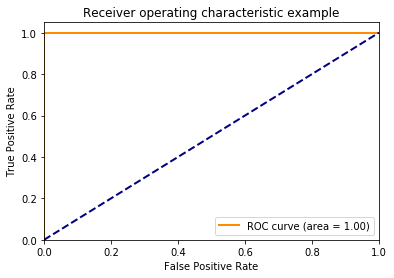

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, lg.predict_proba(X_test[model_cols])[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_test, lg.predict_proba(X_test[model_cols])[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

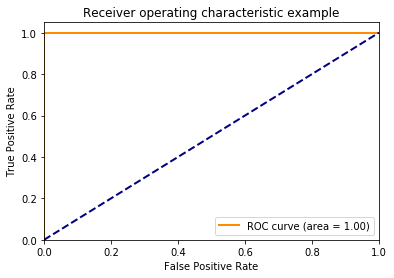

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, lg.predict_proba(X_train[model_cols])[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_train, lg.predict_proba(X_train[model_cols])[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
with open("col_list.txt","w") as f:
    f.write(str(X_test[model_cols].columns.tolist()))